# Histopathologic Cancer Detection

## Brief Description of Problem and Data:

The goal is to use deep learning to detect metastatic cancer in small pathology image patches using the provided [data](https://www.kaggle.com/c/histopathologic-cancer-detection/data).

Each image is labeled based on whether the *center 32×32 pixel region* contains any tumor tissue. Tumor presence outside this central area does not affect the label.

We are given labeled training images and must predict labels for a set of test images. A label of 0 indicates there is no cancer, while a label of 1 indicates the presence of a tumor.

Both the train and test datasets are large and the train data contains 220,025 images and the test set contains 57,468 images.


In [35]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, MaxPooling2D,
    BatchNormalization, ReLU, GlobalAveragePooling2D,
    Dropout, Flatten, Dense, Concatenate, Lambda
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from keras_tuner import HyperParameters
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import keras_tuner as kt

In [3]:
base_path = Path("/kaggle/input/histopathologic-cancer-detection")
train_dir = base_path / "train"
labels_csv = base_path / "train_labels.csv"

# Exploratory Data Analysis

First let's read the labels_csv file and get the count of 1's and 0's in the csv file. 1 in this case indicates the image shows cancer while 0 indicates there was no cancer detected.

In [4]:
labels = pd.read_csv(labels_csv)
labels["id"] = labels["id"] + ".tif"

In [5]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [6]:
labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

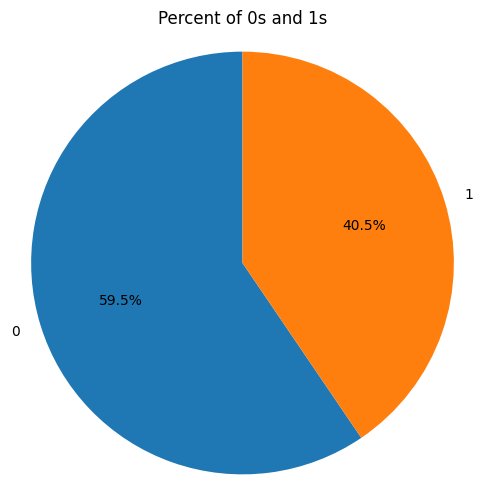

In [7]:
# Get value counts and calculate percentages
label_counts = labels['label'].value_counts()
label_percentages = label_counts / label_counts.sum() * 100

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_percentages, labels=label_percentages.index, autopct='%1.1f%%', startangle=90)
plt.title('Percent of 0s and 1s')
plt.axis('equal')
plt.show()

So we observe about 60% of the labels_csv file images are non-cancerous.

Now lets get some sample images cancerous and non-cancerous images and we'll start by getting a random sample of 5000 for each type.


In [8]:
labels = pd.concat([
    labels[labels.label == 0].sample(5000, random_state=42),
    labels[labels.label == 1].sample(5000, random_state=42)
]).reset_index(drop=True)

In [14]:
def load_images(ids, directory, img_size=128):
    images = []
    for image_id in ids:
        path = directory / image_id
        with Image.open(path) as img:
            img = img.resize((img_size, img_size))
            img = img_to_array(img)
            images.append(img)
    return np.array(images)

X = load_images(labels["id"], train_dir)
y = labels["label"].values

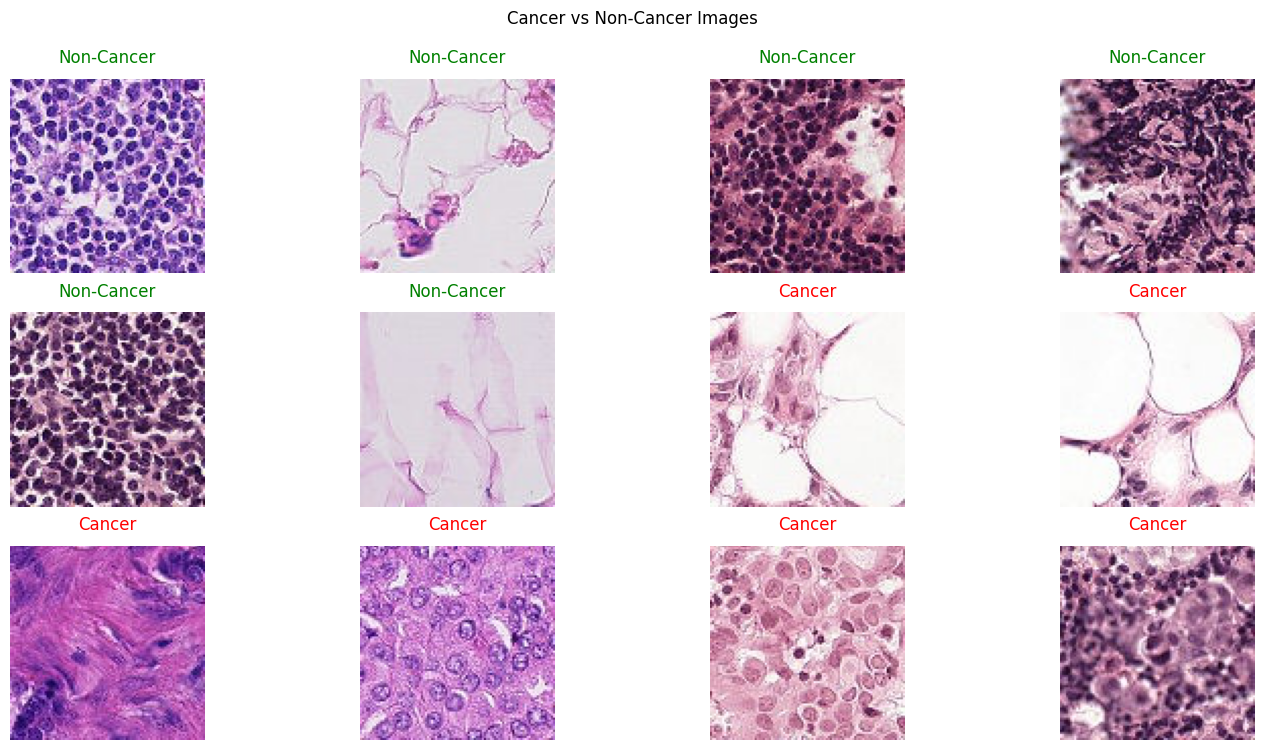

In [15]:
train_dir = Path('/kaggle/input/histopathologic-cancer-detection/train')

# pick samples
cancer_idx     = np.where(y == 1)[0]
non_cancer_idx = np.where(y == 0)[0]
sample_idx = np.concatenate([
    np.random.choice(non_cancer_idx, 6, replace=False),
    np.random.choice(cancer_idx,     6, replace=False),
])

fig, axes = plt.subplots(3, 4, figsize=(14, 7), constrained_layout=True)

for ax, idx in zip(axes.flat, sample_idx):
    img_id   = labels.loc[idx, 'id']
    img_path = train_dir / img_id
    img = Image.open(img_path)

    ax.imshow(img)
    ax.axis('off')

    text = "Cancer" if y[idx] == 1 else "Non‑Cancer"
    ax.set_title(
        text,
        color = 'red'   if text=="Cancer" else 'green',
        pad   = 12
    )

fig.suptitle("Cancer vs Non‑Cancer Images", y=1.05)
plt.show()

# Model Architecture

Now that we've looked at the data, let's build our deep learning model to help with this binary classification of images.

## Model 1

In [16]:
X = X.astype('float32') / 255.0

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Let's make a simple Convolutional Neural Network (CNN). The CNN will have 3 convolutional blocks and each block will consist of Conv2D, BatchNormalization, and MaxPooling2D.

Conv2D applies learnable 3×3 filters across every patch of the image, allowing the network to detect patterns (edges, color blobs, textures). By stacking multiple blocks with increasing filter counts, the model learns a hierarchy of features at progressively coarser spatial resolutions (thanks to pooling).

BatchNormalization normalizes each feature‑map by subtracting its batch mean and dividing by its batch standard deviation, then applies a small, learnable scale and shift. This speeds up convergence and stabilizes training.

MaxPooling2D downsamples each feature‑map by taking the maximum over non‑overlapping 2×2 windows, halving height and width. This reduces computation, adds a bit of translation invariance (so small shifts don’t break detections), and forces the network to focus on the strongest activations.

In [17]:
img_size = X.shape[1]

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same',
           input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # final binary output
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Below is a summary of our model. From the output we can see the model was compiled as expected and we have about 4.29 M total parameters, of which 4.29 M are trainable and only 704 are frozen (the BatchNorm moving stats).

The dense layer accounts for around 98% of the params. We'll have to watch for this as it can make the model prone to overfitting. But we also have a lot of data so it may not end up being a concern.

Spatial reductions via max‑pooling shrink our feature maps from 128² → 64² → 32² → 16² before flattening, so the dense head isn’t super huge, but it’s still the bulk of the network.

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,289,217 (16.36 MB)

 Trainable params: 4,288,513 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)

Now let's train our model and store the results... We will start with 10 epochs, and since our model is small enough it shouldn't take too long to train.

In [19]:
model_1_history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.7040 - loss: 0.6662 - val_accuracy: 0.6030 - val_loss: 1.5257
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.8067 - loss: 0.4454 - val_accuracy: 0.6925 - val_loss: 0.6941
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.8324 - loss: 0.3798 - val_accuracy: 0.8185 - val_loss: 0.4527
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.8417 - loss: 0.3660 - val_accuracy: 0.7760 - val_loss: 0.4921
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.8622 - loss: 0.3267 - val_accuracy: 0.6465 - val_loss: 0.9333
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8779 - loss: 0.2966 - val_accuracy: 0.6390 - val_loss: 1.6125
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.9086 - loss: 0.2237 - val_accuracy: 0.8025 - val_loss: 0.4750
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.9332 - loss: 0.1782 - val_accu

## Model 1 - Results and Analysis

Our results show we are getting some great accuracy, however, we have some inconsistent validation accuracy values while accuracy on the training set increases, which tells us our model is overfitting on the training data. Essentially, our model is memorizing the training set and either guessing or making bad generalizations that it uses when seeing an image for the first time.

Let's plot the loss and accuracy to over the number of epochs so we can visualize just what's going on.

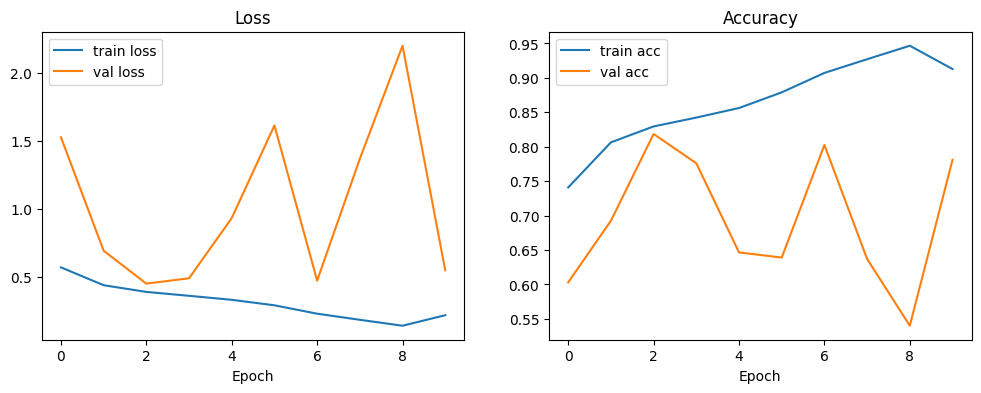

In [20]:
# Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(model_1_history.history['loss'],    label='train loss')
plt.plot(model_1_history.history['val_loss'],label='val loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(model_1_history.history['accuracy'],    label='train acc')
plt.plot(model_1_history.history['val_accuracy'],label='val acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()

We can visually see the models inability to generalize and we see huge loss spikes. Now let's look at the confusions matrix and it should confirm our findings.

In [25]:
y_pred_prob = model_1_history.model.predict(X_val)
y_pred      = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)

print(classification_report(y_val, y_pred, target_names=['non‑cancer','cancer']))

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step
Confusion matrix:
 [[887 113]
 [325 675]]
              precision    recall  f1-score   support

  non‑cancer       0.73      0.89      0.80      1000
      cancer       0.86      0.68      0.76      1000

    accuracy                           0.78      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.79      0.78      0.78      2000



Although the numbers themselves don't look terrible, because our model is clearly struggling to generalize we can officially throw this version in the garbage and start to make some improvements.

## Model 2

We will start making a couple changes to our model with data augmentation. ImageDataGenerator makes sure that every batch the model sees has slightly different versions of our patches. This should make the model more robust and fix our major overfitting problem.

We are also making a list of callbacks that automatically adjusts parts of the model as it trains. In this case we have ReduceLROnPlateau which watches the validation loss. If it doesn’t improve for 2 consecutive epochs, it halves the learning rate. EarlyStopping also watches validation loss. It will help us save some time by stopping the training early if validation loss fails to improve for 4 epochs in a row. Lastly we have ModelCheckpoint which also checks validation loss and saves the model weights if that epoch produced the lowest val_loss so far.

In [54]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='reflect'
)

train_gen = train_datagen.flow(
    X_train,
    y_train,
    batch_size=32
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

Now we will compile the model with a lower learning rate and start training with the augmented data and callbacks we added.

In [27]:
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [28]:
model_2_history = model.fit(
    train_gen,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.8092 - loss: 0.5065 - val_accuracy: 0.8390 - val_loss: 0.3976 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.8284 - loss: 0.4169 - val_accuracy: 0.8365 - val_loss: 0.3809 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.8244 - loss: 0.4162 - val_accuracy: 0.8100 - val_loss: 0.4250 - learning_rate: 1.0000e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.8329 - loss: 0.3821 - val_accuracy: 0.8335 - val_loss: 0.3981 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.8417 - loss: 0.3760 - val_accuracy: 0.8400 - val_loss: 0.3775 - learning_rate: 5.0000e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.8281 - loss: 0.3992 - val_accuracy: 0.8210 - val_loss: 0.4065 - learning_rate: 5.0000e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.83

## Model 2 - Results and Analysis

We have some interesting results here. We can see right away our validation accuracy has improved a lot from the first model and the validation loss tells us we are not doing the same random guessing seen in the first model. Additionally, we can see at epoch 5 our callbacks triggered a lower learning rate.

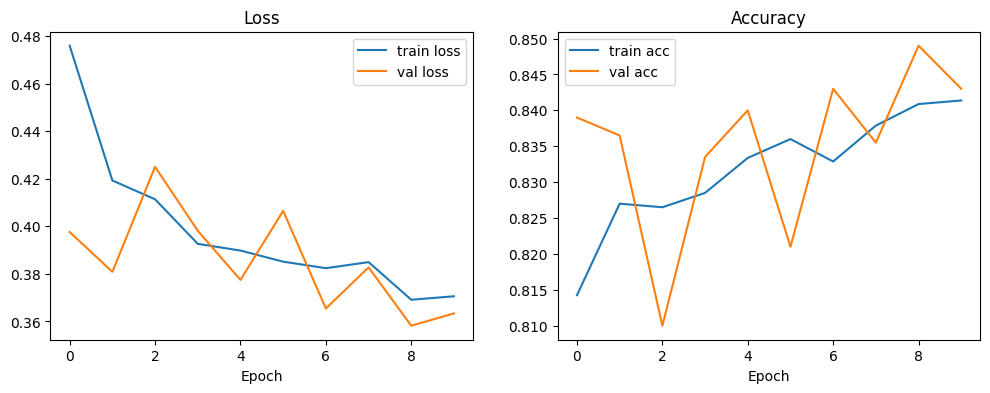

In [29]:
# Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(model_2_history.history['loss'],    label='train loss')
plt.plot(model_2_history.history['val_loss'],label='val loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(model_2_history.history['accuracy'],    label='train acc')
plt.plot(model_2_history.history['val_accuracy'],label='val acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()

In [30]:
y_pred_prob = model_2_history.model.predict(X_val)
y_pred      = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)

print(classification_report(y_val, y_pred, target_names=['non‑cancer','cancer']))

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step
Confusion matrix:
 [[896 104]
 [198 802]]
              precision    recall  f1-score   support

  non‑cancer       0.82      0.90      0.86      1000
      cancer       0.89      0.80      0.84      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



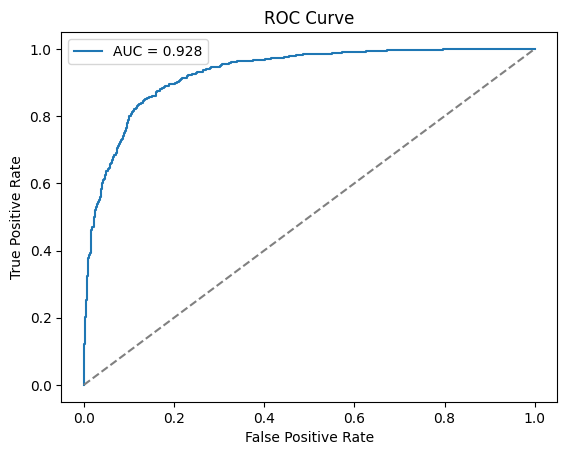

In [31]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Most notable from our results is the ROC curve, which shows we can achieve a high true positive rate with a low false positive rate. Our AUC value is also 0.928 and we have a few key takeaways:

- Our model is good and reliable at distinguishing cancer from non-cancer images.

- While the validation loss and validation accuracy seem to jump around, it's mostly just because the scale of the y axis is so small. Overall they're actually pretty consistent and there isn't any cause for concern here.

- We also see the curve bow sharply upwards which is a very good sign, since this indicates we can pick a lower threshold to boost model sensitivity and only see a pretty small increase in false alarms.

- Lastly, our model performed really well and seems very robust as indicated by the very high AUC score. Overall we can say this model has excellent predictive power when differentiating between cancer and non-cancer images.

## Hyperparameter Tuning

Now let's tune our hyperparameters for this model. Below we define a function, build_model, which will compile for us a "fresh" model for each time we run our search for hyperparameter tuning. The model we define in the function is also the same as the one we defined above as the second model. 

In [33]:
def build_model(hp):
    """Returns a compiled scratch CNN identical to the one used in Model 2"""
    img_size = X_train.shape[1]
    inputs   = tf.keras.Input((img_size, img_size, 3))

    # Block 1
    x = Conv2D(
            filters=hp.Int('f1', 16, 64, step=16),
            kernel_size=3, padding='same', activation='relu')(inputs)
    x = BatchNormalization(
            momentum=0.99 if 'bn_mom' not in hp else
                      hp.Float('bn_mom', 0.8, 0.99, step=0.05))(x)
    x = MaxPooling2D()(x)

    # Block 2
    x = Conv2D(
            filters=hp.Int('f2', 32, 128, step=32),
            kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Block 3
    x = Conv2D(
            filters=hp.Int('f3', 64, 256, step=64),
            kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Head
    x = Flatten()(x)
    x = Dense(hp.Int('fc', 64, 512, step=64), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('drop', 0.0, 0.6, step=0.1))(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs, name='model_2_cnn_replica')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('lr', [1e-3, 5e-4, 1e-4, 5e-5])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

Note: We could be more thorough in searching for the best hyperparameters below, however, it already takes so much time to train this basic search that it just doesn't seem worth it at the moment. Instead, we will start here, analyze our results, and implement other methods later on.

In [36]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=1,
    overwrite=True,
)

In [37]:
tuner.search(train_gen,
             validation_data=(X_val, y_val),
             epochs=3)
best_hp = tuner.get_best_hyperparameters(1)[0]

Trial 4 Complete [00h 21m 08s]
val_accuracy: 0.7839999794960022

Best val_accuracy So Far: 0.8335000276565552
Total elapsed time: 01h 18m 27s


In [38]:
print("Best hyperparameters found:")
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")

Best hyperparameters found:
f1: 48
f2: 64
f3: 192
fc: 192
drop: 0.0
lr: 0.0001


In [42]:
original_hp_model_2 = {
    'f1': 32,
    'f2': 64,
    'f3': 128,
    'fc': 128,
    'drop': 0.5,
    'lr': 1e-3
}

In [49]:
print(f"{'Parameter':<10} | {'Original':<10} | {'Tuned':<10}")
print("-" * 35)

for key in original_hp_model_2:
    orig_val = original_hp_model_2[key]
    tuned_val = best_hp.get(key)
    print(f"{key:<10} | {str(orig_val):<10} | {str(tuned_val):<10}")

Hyperparameter Comparison:

Parameter  | Original   | Tuned     
---------------------------------------------
f1         | 32         | 48        
f2         | 64         | 64        
f3         | 128        | 192       
fc         | 128        | 192       
drop       | 0.5        | 0.0       
lr         | 0.001      | 0.0001    


In [56]:
best_model  = tuner.hypermodel.build(best_hp)

best_model_history = best_model.fit(
    train_gen,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.7546 - loss: 0.5627 - val_accuracy: 0.5000 - val_loss: 4.4182 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.8127 - loss: 0.4250 - val_accuracy: 0.6635 - val_loss: 0.7696 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.8221 - loss: 0.3991 - val_accuracy: 0.7750 - val_loss: 0.4841 - learning_rate: 1.0000e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.8206 - loss: 0.4046 - val_accuracy: 0.7880 - val_loss: 0.4477 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.8262 - loss: 0.3935 - val_accuracy: 0.7745 - val_loss: 0.5015 - learning_rate: 1.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.8416 - loss: 0.3651 - val_accuracy: 0.8040 - val_loss: 0.4382 - learning_rate: 1.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.83

## Hyperparameter Tuning - Results and Analysis

Again we have some interesting results and we actually seem to get less favorable results than when we did not use the hyperparameters we found as optimal using our brief tuning method. However, lets look at the charts and see what we find as there may be indicators that tell us this is a better model despite it having lower val_accuracy for most epochs.

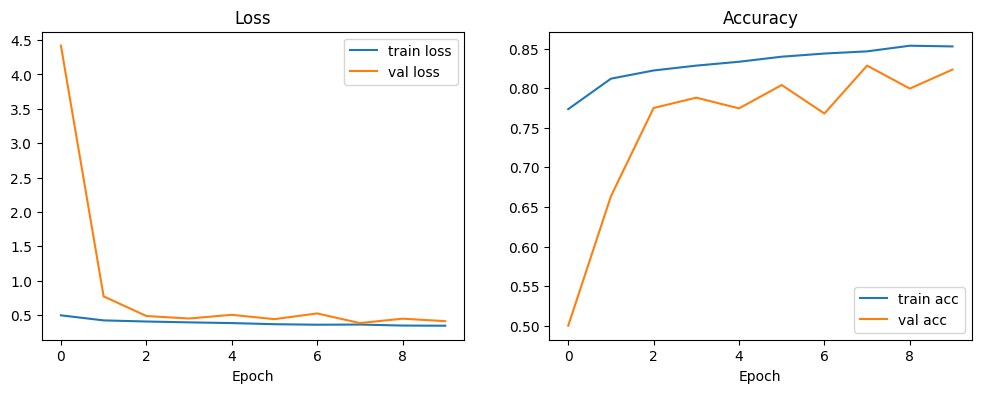

In [57]:
# loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(best_model_history.history['loss'],    label='train loss')
plt.plot(best_model_history.history['val_loss'],label='val loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

# accuracy
plt.subplot(1,2,2)
plt.plot(best_model_history.history['accuracy'],    label='train acc')
plt.plot(best_model_history.history['val_accuracy'],label='val acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()

In [58]:
y_pred_prob = best_model_history.model.predict(X_val)
y_pred      = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)

print(classification_report(y_val, y_pred, target_names=['non‑cancer','cancer']))

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step
Confusion matrix:
 [[913  87]
 [256 744]]
              precision    recall  f1-score   support

  non‑cancer       0.78      0.91      0.84      1000
      cancer       0.90      0.74      0.81      1000

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000



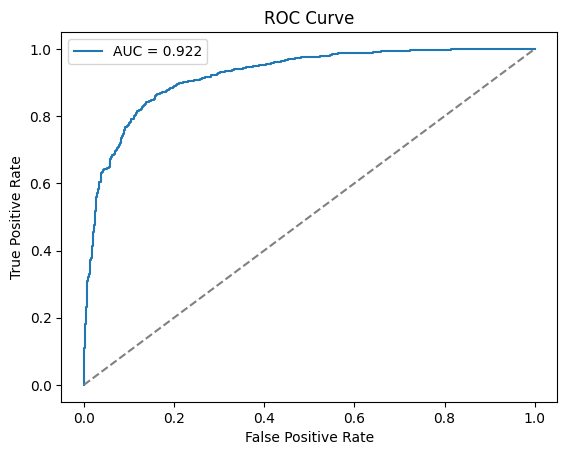

In [59]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Overall we see this is very comparable to the results we got without our hyperparameter tuning. This model has an AUC of .922 which is excellent and almost identical to the original value of model 2. If we had to pick one model, I would still choose the original model 2 since it has higher overall accuracy and a better balance between precision and recall for both classes. However, both models have proven to be effective.

## ResNet50 Model

Finally, let's try using transfer learning to see if we can further improve our model. 

In [67]:
N, H, W, C = X.shape
print(f"Our patches are {H}×{W} pixels, with {C} channels.")

Our patches are 128×128 pixels, with 3 channels.


In [68]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow(
    X_train, y_train,
    batch_size=32
)
val_gen = val_datagen.flow(
    X_val,   y_val,
    batch_size=32,
    shuffle=False
)

In [69]:
base = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)
base.trainable = False 

x = base.output
x = GlobalAveragePooling2D(name='gap')(x)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dropout(0.5, name='dropout')(x)
outputs = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(inputs=base.input, outputs=outputs, name='ResNet50V2_transfer')

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [71]:
model_resnet_history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    ## Getting rid of early stopping
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)],
    verbose=1
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 247s 987ms/step - accuracy: 0.5370 - loss: 0.7033 - val_accuracy: 0.6940 - val_loss: 0.6121 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 246s 979ms/step - accuracy: 0.6387 - loss: 0.6312 - val_accuracy: 0.7045 - val_loss: 0.5856 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 244s 974ms/step - accuracy: 0.6878 - loss: 0.5915 - val_accuracy: 0.7075 - val_loss: 0.5734 - learning_rate: 1.0000e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 246s 980ms/step - accuracy: 0.7083 - loss: 0.5735 - val_accuracy: 0.7055 - val_loss: 0.5705 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.7155 - loss: 0.5612 - val_accuracy: 0.7155 - val_loss: 0.5601 - learning_rate: 1.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 242s 965ms/step - accuracy: 0.7216 - loss: 0.5583 - val_accuracy: 0.7120 - val_loss: 0.5646 - learning_rate: 1.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 299

## ResNet50 Model - Results and Analysis

Now let's look at the evaluation methods we've been using to determine how this model performs relative to our other models. Initially, we see lower validation accuracy scores than without transfer learning. However, this model does seem very robust (accuracy scores are consistent with validation accuracy scores) so maybe with our evaluation we'll see some good metrics. We've also frozen the backbone of ResNet50 to save time, and so we should keep in mind with fine-tuning and unfreezing it we would likely see a boost in model performance.

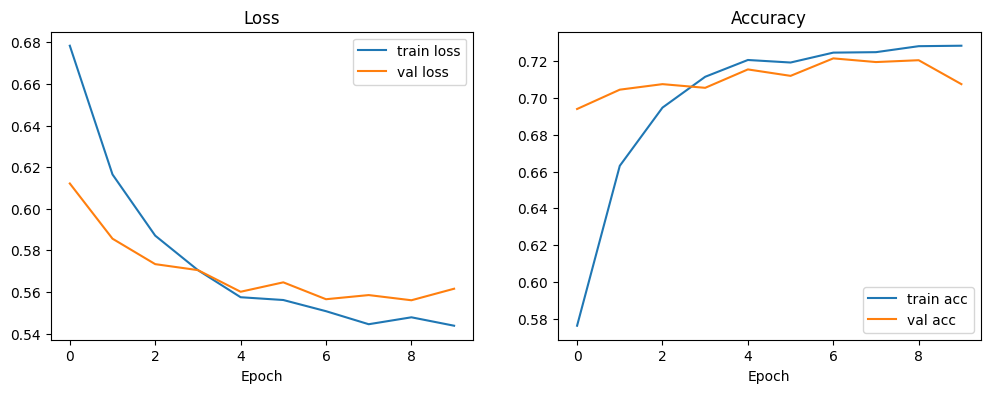

In [72]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(model_resnet_history.history['loss'],    label='train loss')
plt.plot(model_resnet_history.history['val_loss'],label='val loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(model_resnet_history.history['accuracy'],    label='train acc')
plt.plot(model_resnet_history.history['val_accuracy'],label='val acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()

In [73]:
y_pred_prob = model_resnet_history.model.predict(val_gen, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

y_true = y_val

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
print(classification_report(
    y_true,
    y_pred,
    target_names=['non‑cancer','cancer']
))

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 776ms/step
Confusion matrix:
 [[772 228]
 [357 643]]
              precision    recall  f1-score   support

  non‑cancer       0.68      0.77      0.73      1000
      cancer       0.74      0.64      0.69      1000

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000



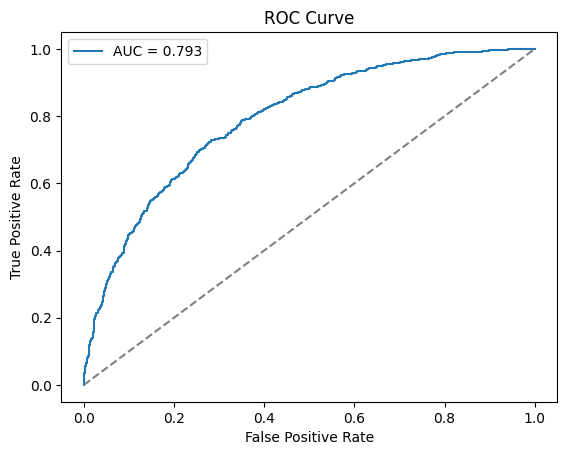

In [74]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Conclusion

Now let's recap what we covered in this notebook. Our first model was just a basic CNN with 3 convolutional blocks. We found that this model worked okay and had pretty good accuracy numbers, but on the other hand, it's validation accuracy left a lot to be desired, indicating that our model mostly, started to memorize the dataset without effectively being able to generalize the findings on the validation set.

In the second model we seeked to solve the problems in the first model. We used data augmentation and added callbacks so our model can adjust things like the learning rate on the fly. Ultimately, we found this model worked very well and was significantly more robust than the first model. It had both an excellent AUC score and a consistently good validation accuracy.

Next we looked to further improve the second model with hyperparameter tuning. We did this fairly quickly using keras-tuner with 4 trials and 3 epochs each. While this means we may not have found the perfect hyperparameters, we did find pretty good ones without having extreme training times. However, this did not significantly improve our second model, meaning we had pretty good hyperparamters to start, and with the original AUC score, there wasn't a ton of room for improvement, so we are still happy with this result.

Lastly, we used transfer learning with ResNet50. ResNet50 is an extremely impressive CNN and it quickly got a solid validation accuracy and showed a robust AUC score of 0.793. However, the actual performance of the model does not actually seem much better than our second model. This tells us our second model was very good, but also, maybe we would need to work on tuning hyperparameters, unfreezing the backbone, or adjusting the training data to really get the most out of this model.